<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/forward_forward/forward_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forward-Forward for image classification
##Setup imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

##Load the dataset

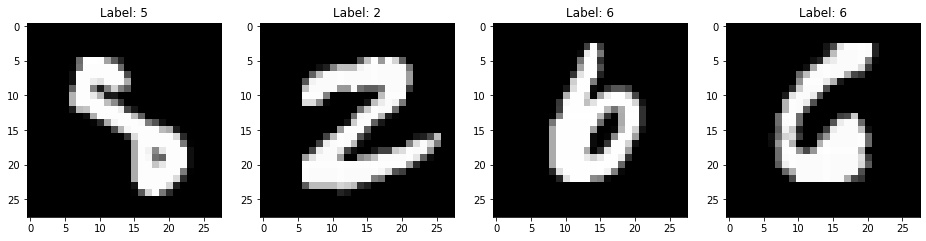

In [28]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

idx1, idx2, idx3, idx4 = random.sample(range(0, X_train.shape[0]), 4)

img1 = (X_train[idx1], y_train[idx1])
img2 = (X_train[idx2], y_train[idx2])
img3 = (X_train[idx3], y_train[idx3])
img4 = (X_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(16, 4))
for idx, item in enumerate(imgs):
  img, label = item[0], item[1]
  plt.subplot(1, 4, idx + 1)
  plt.imshow(img, cmap='gray')
  plt.title(f'Label: {label}')
plt.show()

##Define `ForwardForwardDense` custom layer



In [44]:
class ForwardForwardDense(keras.layers.Layer):
  def __init__(
      self,
      units,
      optimizer,
      loss_metric,
      num_epochs=50,
      use_bias=True,
      kernel_initializer='glorot_uniform',
      bias_initializer='zeros',
      kernel_regularizer=None,
      bias_regularizer=None,
      **kwargs
  ):
    super().__init__(**kwargs)
    self.dense = keras.layers.Dense(
        units=units,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        bias_initializer=bias_initializer,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer
    )
    self.relu = keras.layers.ReLU()
    self.optimizer = optimizer
    self.loss_metric = loss_metric
    self.threshold = 1.5
    self.num_epochs = num_epochs

  # Performs normalization step before the input though the dense layer.
  def call(self, X):
    X_norm = tf.norm(X, ord=2, axis=1, keepdims=True)
    X_norm = X_norm + 1e-4
    X_dir = X / X_norm
    res = self.dense(X_dir)
    return self.relu(res)

  def forward_forward(self, X_pos, X_neg):
    for i in range(self.num_epochs):
      with tf.GradientTape() as tape:
        g_pos = tf.math.reduce_mean(tf.math.pow(self.call(X_pos), 2), 1)
        g_neg = tf.math.reduce_mean(tf.math.pow(self.call(X_neg), 2), 1)
        loss = tf.math.log(
            1 + tf.math.log(1 + tf.math.exp(tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)))
        )
        mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
        self.loss_metric.update_state([mean_loss])
      gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
      self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
    return (
        tf.stop_gradient(self.call(X_pos)),
        tf.stop_gradient(self.call(X_neg)),
        self.loss_metric.result()
    )

##Define `ForwardForwardDense` custom layer

In [46]:
class ForwardForwardModel(keras.Model):
  def __init__(self, dims, layer_optimizer=keras.optimizers.Adam(learning_rate=0.03), ** kwargs):
    super().__init__(**kwargs)
    self.layer_optimizer = layer_optimizer
    self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    self.layer_list = [keras.Input(shape=(dims[0],))]
    for d in range(len(dims) - 1):
      self.layer_list += [
          ForwardForwardDense(dims[d + 1], optimizer=self.layer_optimizer, loss_metric=keras.metrics.Mean())
      ]
  
  @tf.function(reduce_retracing=True)
  def overlay_y_on_x(self, data):
    X_sample, y_sample = data
    max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
    max_sample = tf.cast(max_sample, dtype=tf.float64)
    X_zeros = tf.zeros([10], dtype=tf.float64)
    X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
    X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
    return X_sample, y_sample

  @tf.function(reduce_retracing=True)
  def predict_one_sample(self, X):
    goodness_per_label = []
    X = tf.reshape(X, [tf.shape(X)[0] * tf.shape(X)[1]])
    for label in range(10):
      h, label = self.overlay_y_on_x(data=(X, label))
      h = tf.reshape(h, [-1, tf.shape(h)[0]])
      goodness = []
      for layer_idx in range(1, len(self.layer_list)):
        layer = self.layer_list[layer_idx]
        h = layer(h)
        goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
      goodness_per_label += [
          tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
      ]
    goodness_per_label = tf.concat(goodness_per_label, 1)
    return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

  def predict(self, data):
    X = data
    preds = list()
    preds = tf.map_fn(fn=self.predict_one_sample, elems=X)
    return np.asarray(preds, dtype=int)

  @tf.function(jit_compile=True)
  def train_step(self, data):
    X, y = data
    X = tf.reshape(X, [-1, tf.shape(X)[1] * tf.shape(X)[2]])
    X_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(X, y))
    random_y = tf.random.shuffle(y)
    X_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(X, random_y))
    h_pos, h_neg = X_pos, X_neg
    for idx, layer in enumerate(self.layers):
      if isinstance(layer, ForwardForwardDense):
        print(f'Training layer {idx+1} now: ')
        h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
        self.loss_var.assign_add(loss)
        self.loss_count.assign_add(1.0)
      else:
        print(f'Passing layer {idx+1} now: ')
        X = layer(X)
    mean_res = tf.math.divide(self.loss_var, self.loss_count)
    return {'Final loss': mean_res}

##Convert MNIST numpy arrays to `tf.data.Dataset`

In [41]:
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

##Train the network

In [ ]:
model = ForwardForwardModel(dims=[784, 500, 500])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss='mse',
    jit_compile=True,
    metrics=[keras.metrics.Mean()]
)
history = model.fit(train_dataset, epochs=30)

##Inference and testing

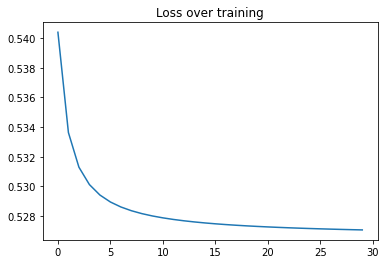

In [49]:
preds = model.predict(tf.convert_to_tensor(X_test))
preds = preds.reshape((preds.shape[0], preds.shape[1]))
results = accuracy_score(preds, y_test)

plt.plot(range(len(history.history['Final loss'])), history.history['Final loss'])
plt.title('Loss over training')
plt.show()

##Conclusions
Comparing to backpropagation the training process (5 mins for 30 epochs!) turned out to be surprisingly long for such a simple task. 

For two executed training sesions the loss function seemed to stuck on the local minimum.